## 1. Feature Engineering

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [18]:
df = pd.read_parquet('/Users/dianaterraza/Desktop/portfolio_project/data/processed_data.parquet')

In [19]:
df.head()

,SGD_USD,CNY_USD
DATE,,
2000-01-03,1.6563,8.2798
2000-01-04,1.6535,8.2799
2000-01-05,1.6560,8.2798
2000-01-06,1.6655,8.2797
2000-01-07,1.6625,8.2794


In [20]:
# Create a copy to work with
df_model = df.copy()

# Handle any missing values
df_model['SGD_USD'] = df_model['SGD_USD'].fillna(method='ffill')

/var/folders/p6/1v6w0vgj3d951b4r8sgj0lgw0000gn/T/ipykernel_13387/2395012321.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model['SGD_USD'] = df_model['SGD_USD'].fillna(method='ffill')


In [21]:
# 1.1 Creating lag features (past values)
for lag in [1, 3, 7, 14, 21, 30]:
    df_model[f'lag_{lag}d'] = df_model['SGD_USD'].shift(lag)

# 1.2 Percentage changes
df_model['pct_change_1d'] = df_model['SGD_USD'].pct_change() * 100
df_model['returns'] = np.log(df_model['SGD_USD'] / df_model['SGD_USD'].shift(1))

In [22]:
# 1.3 Moving averages
for window in [7, 14, 30, 90]:
    df_model[f'ma_{window}d'] = df_model['SGD_USD'].rolling(window=window).mean()
    
    # Relative position to moving average
    df_model[f'ma_diff_{window}d'] = df_model['SGD_USD'] - df_model[f'ma_{window}d']
    df_model[f'ma_diff_pct_{window}d'] = (df_model['SGD_USD'] / df_model[f'ma_{window}d'] - 1) * 100


In [23]:
# 1.4 Volatility metrics
for window in [7, 14, 30, 90]:
    df_model[f'volatility_{window}d'] = df_model['pct_change_1d'].rolling(window=window).std()

# 1.5 Momentum indicators
for window in [7, 14, 30]:
    df_model[f'momentum_{window}d'] = df_model['SGD_USD'] / df_model['SGD_USD'].shift(window) - 1

# 1.6 Calendar features
df_model['day_of_week'] = df_model.index.dayofweek
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model['year'] = df_model.index.year

In [24]:
df.head()

,SGD_USD,CNY_USD
DATE,,
2000-01-03,1.6563,8.2798
2000-01-04,1.6535,8.2799
2000-01-05,1.6560,8.2798
2000-01-06,1.6655,8.2797
2000-01-07,1.6625,8.2794


##  2. Split the data in Train and Test

In [28]:
# Split data into training and testing sets (80/20 split)
train_size = int(len(df_model) * 0.8)
train = df_model[:train_size]
test = df_model[train_size:]

# Define target and features
target_col = 'SGD_USD'
feature_cols = [col for col in df_model.columns if col != target_col]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

### How to Know if Seasonality Is Present

1. Visual Inspection
Plot the time series using matplotlib or plotly.

Look for repeating patterns at regular intervals (daily, weekly, monthly, etc.).

In [29]:
# Split data into training and testing sets (80/20 split)
train_size = int(len(df_model) * 0.8)
train = df_model[:train_size]
test = df_model[train_size:]

# Define target and features
target_col = 'SGD_USD'
feature_cols = [col for col in df_model.columns if col != target_col]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

<Axes: title={'center': 'Time Series Plot'}, xlabel='DATE'>

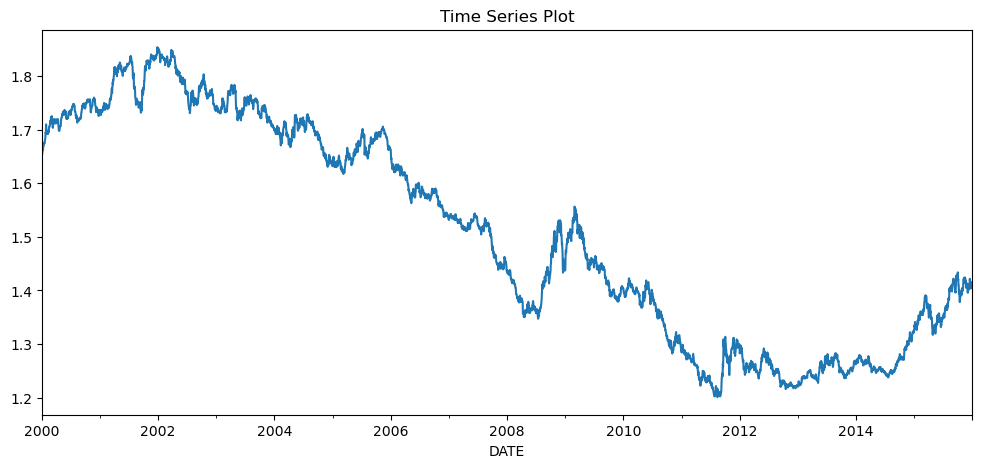

In [30]:
train[target_col].plot(figsize=(12, 5), title='Time Series Plot')


2. Decompose the Time Series

Use seasonal decomposition to split the data into trend, seasonality, and residual components:



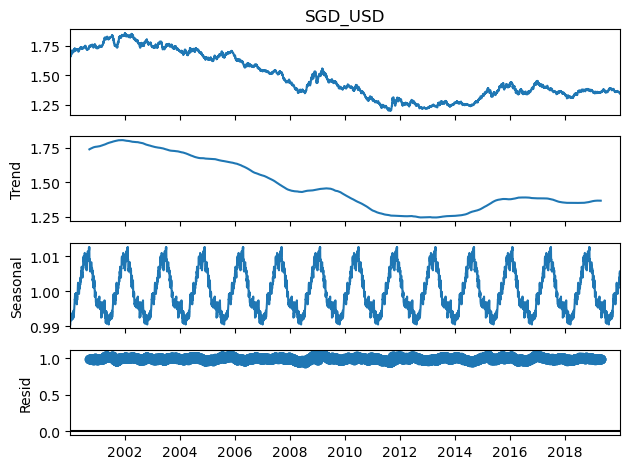

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_model['SGD_USD'], model='multiplicative', period=365)
df_model['seasonal'] = decomposition.seasonal
df_model['trend'] = decomposition.trend
df_model['residual'] = decomposition.resid
decomposition.plot()
plt.show()

In [32]:
# Drop rows with NaN values (created due to lag features)
df_model = df_model.dropna()

## 2. Model Selection

In [10]:
# Split data into training and testing sets (80/20 split)
train_size = int(len(df_model) * 0.8)
train = df_model[:train_size]
test = df_model[train_size:]

# Define target and features
target_col = 'SGD_USD'
feature_cols = [col for col in df_model.columns if col != target_col]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

### ARIMA MODEL

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30384.010, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30382.931, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30382.983, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30384.494, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30381.416, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.417 seconds
Best ARIMA model: (0, 1, 0)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


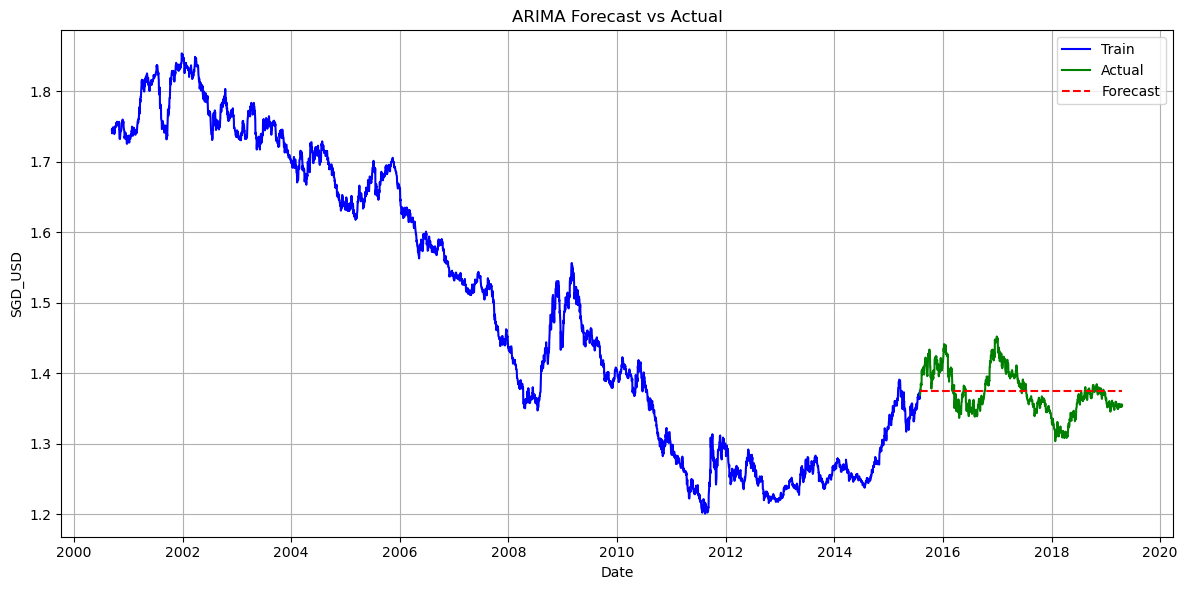

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA (your original code)
arima_model = pm.auto_arima(
    train[target_col],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    m=1, d=None, seasonal=False,
    start_P=0, start_Q=0,
    trace=True, error_action='ignore',
    suppress_warnings=True, stepwise=True
)
print(f"Best ARIMA model: {arima_model.order}")

arima = ARIMA(train[target_col], order=arima_model.order)
arima_fit = arima.fit()

# Forecast for the length of the test set
n_periods = len(test)
forecast = arima_fit.forecast(steps=n_periods)

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[target_col], label='Train', color='blue')
plt.plot(test.index, test[target_col], label='Actual', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')

plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### How to Know if Seasonality Is Present


### SARIMA MODEL (with seasonality)

In [12]:
# Example: Assume weekly seasonality (s=5 for business days)
sarima = SARIMAX(
    train[target_col],
    order=arima_model.order,
    seasonal_order=(1, 0, 1, 5)
)
sarima_fit = sarima.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


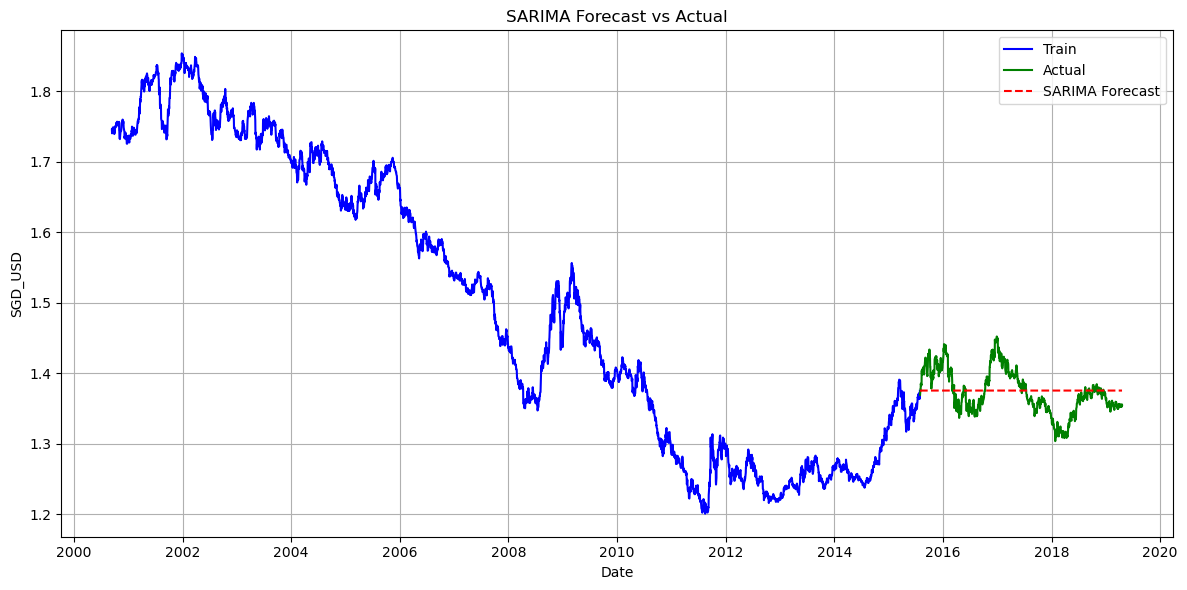

In [13]:
import matplotlib.pyplot as plt

# Plot SARIMA forecast vs actual
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train[target_col], label='Train', color='blue')

# Plot actual test data
plt.plot(test.index, test[target_col], label='Actual', color='green')

# Plot SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Optional: Add title and labels
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Combined Plot: ARIMA vs SARIMA vs Actual

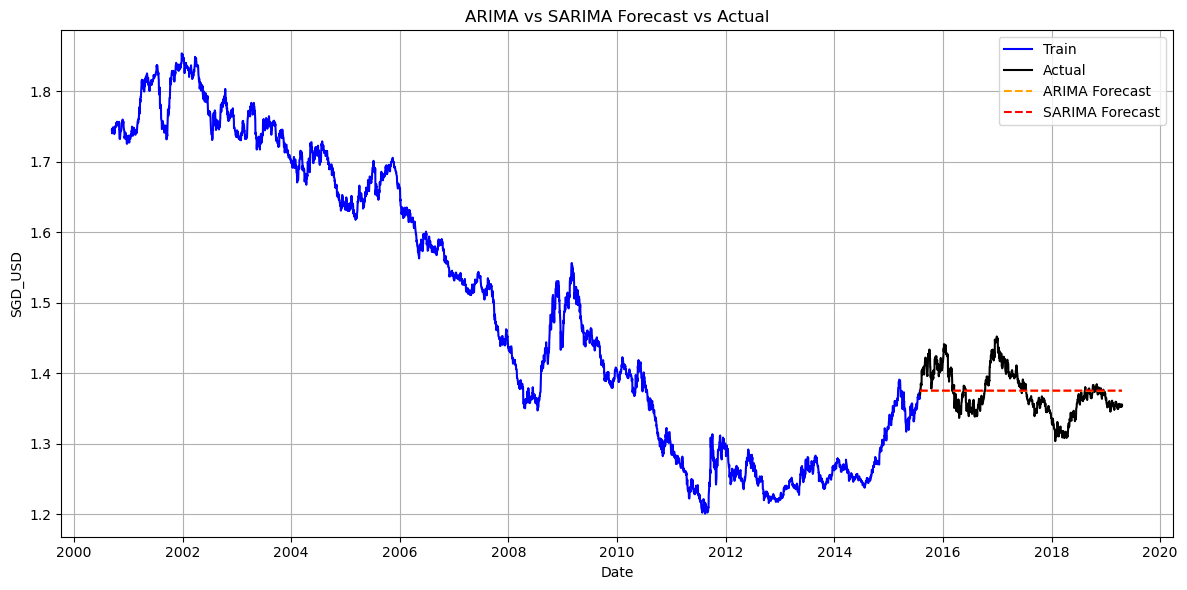

In [14]:
import matplotlib.pyplot as plt

# Forecasts
arima_forecast = arima_fit.forecast(steps=len(test))
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Plot everything
plt.figure(figsize=(12, 6))

# Train data
plt.plot(train.index, train[target_col], label='Train', color='blue')

# Actual test data
plt.plot(test.index, test[target_col], label='Actual', color='black')

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Formatting
plt.title('ARIMA vs SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### RANDOM FOREST 